In [4]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import yfinance as yf

Columns in aapl_df after loading: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits', 'stock', 'date_only']
=== AAPL Stock Data Sample ===


,Date,Open,High,Low,Close,Volume,stock
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,135480400.0,AAPL
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,146322800.0,AAPL
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,118387200.0,AAPL
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,108872000.0,AAPL
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,132079200.0,AAPL



=== S&P 500 Data Sample ===


,Date,Open,High,Low,Close,Volume
1,2020-01-02,3244.669922,3258.139893,3235.530029,3257.850098,3.459930e+09
2,2020-01-03,3226.360107,3246.149902,3222.340088,3234.850098,3.484700e+09
3,2020-01-06,3217.550049,3246.840088,3214.639893,3246.280029,3.702460e+09
4,2020-01-07,3241.860107,3244.909912,3232.429932,3237.179932,3.435910e+09
5,2020-01-08,3238.590088,3267.070068,3236.669922,3253.050049,3.726840e+09



=== AAPL Data with Indicators and Metrics ===


,Close,SMA_20,RSI_14,MACD,BB_Upper,ADX,Stoch_K,Returns,Sharpe
Date,,,,,,,,,
2020-12-23,130.960007,124.106000,66.417825,3.154518,132.469160,19.541019,81.249492,-0.007000,6.182994
2020-12-24,131.970001,124.903000,67.866386,3.323474,133.071583,20.490430,80.317913,0.007683,1.218298
2020-12-28,136.690002,125.908001,73.597952,3.794496,134.663063,22.103937,84.971476,0.035141,1.218298
2020-12-29,134.869995,126.699000,68.522632,3.975103,135.688185,23.837380,86.025970,-0.013404,1.218298
2020-12-30,133.720001,127.249000,65.451324,3.979567,136.538125,25.041166,82.663061,-0.008563,1.218298
2020-12-31 00:00:00+00:00,132.690002,127.729500,62.738934,3.855547,137.100152,25.460360,72.775822,-0.007732,1.218298


Columns in aapl_df: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends',
       'Stock Splits', 'stock', 'date_only', 'Close_sp500', 'SMA_20', 'RSI_14',
       'MACD', 'MACD_Signal', 'MACD_Hist', 'BB_Upper', 'BB_Middle', 'BB_Lower',
       'ADX', 'Stoch_K', 'Stoch_D', 'Returns', 'Volatility', 'Sharpe',
       'Cum_Returns'],
      dtype='object')


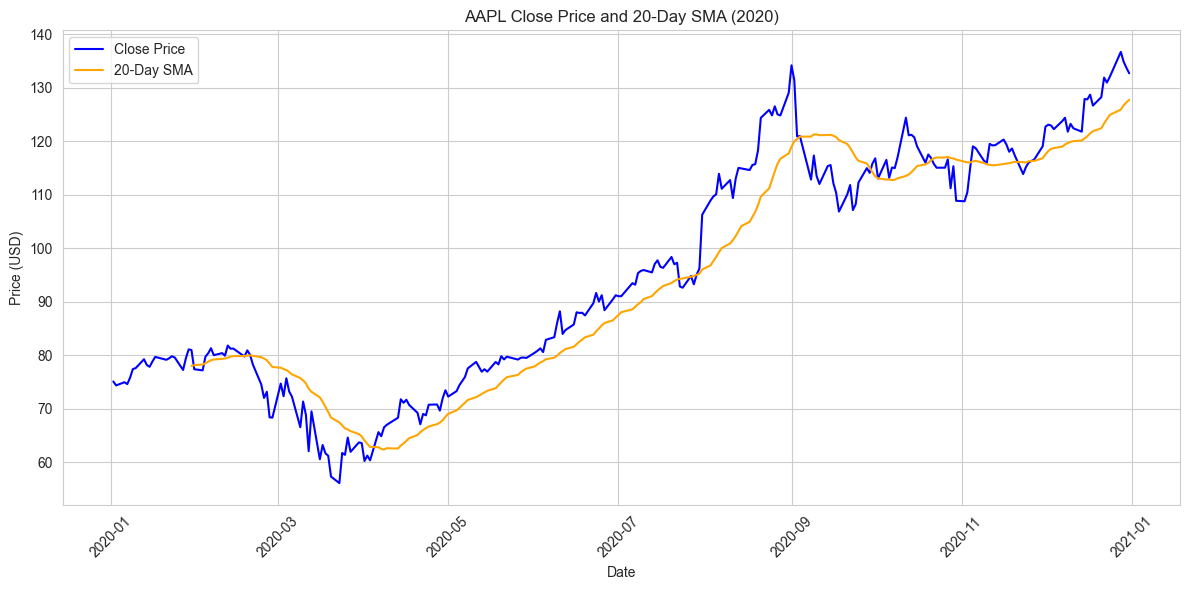

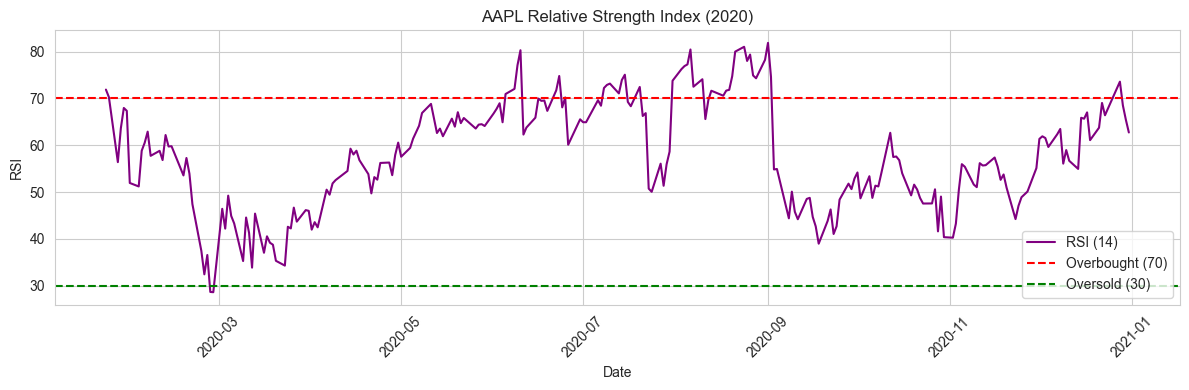

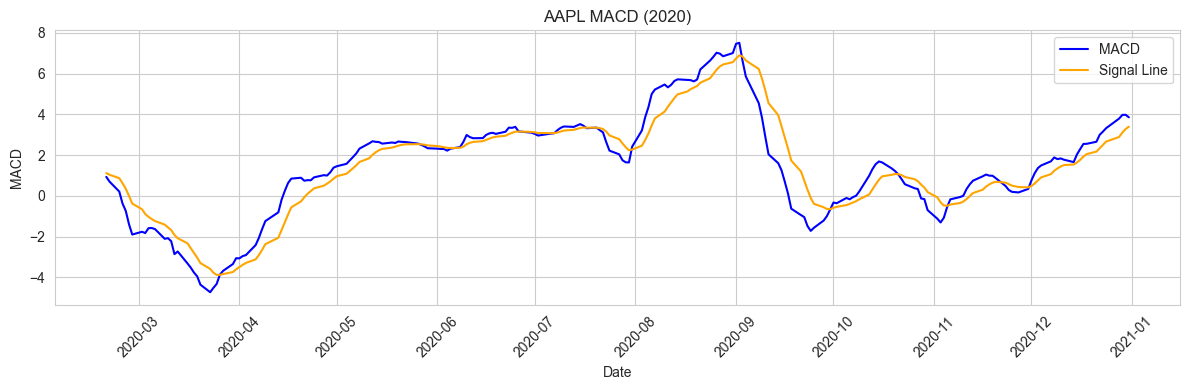

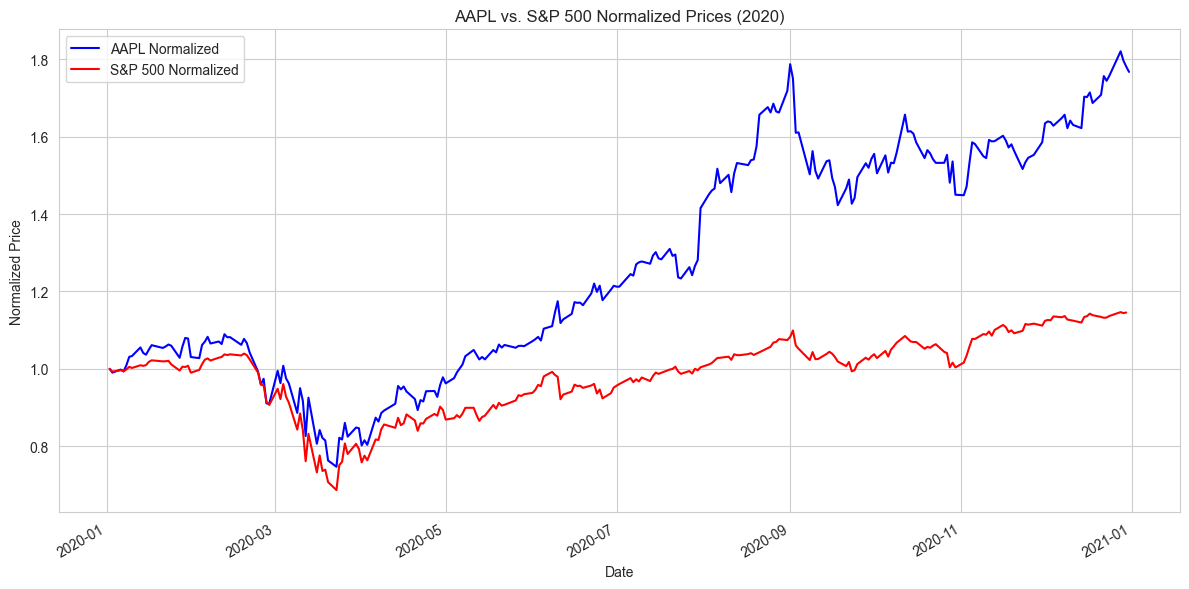

Index(['Close_aapl', 'Close_sp500'], dtype='object')


In [5]:


# ---
# title: Quantitative Analysis for 2020 AAPL Stock Data
# description: Notebook to load stock data and compute technical indicators
# ---

# ### 1. Adjust Python Path
# Add project root to Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.finance_utils import load_stock_data, compute_technical_indicators, compute_financial_metrics

# Set plot style
sns.set_style("whitegrid")

# ### 2. Load AAPL Stock Data
aapl_file = '../data/stock_prices_cleaned_2020.csv'
aapl_df = load_stock_data(aapl_file)
if aapl_df is None:
    raise SystemExit("Failed to load AAPL data. Check file path or regenerate with yfinance.")
print("Columns in aapl_df after loading:", aapl_df.columns.tolist())
if 'Date' not in aapl_df.columns:
    raise KeyError("Date column not found in AAPL data. Ensure stock_prices_cleaned_2020.csv has 'Date'.")
print("=== AAPL Stock Data Sample ===")
display(aapl_df.head())

# Ensure Date is in datetime format with UTC timezone
aapl_df['Date'] = pd.to_datetime(aapl_df['Date'], utc=True)

# ### 3. Load Additional Financial Data (S&P 500)
sp500_file = '../data/sp500_historical_data_2020.csv'

def fetch_sp500_data():
    """Fetch S&P 500 data for 2020 using yfinance."""
    try:
        sp500 = yf.download('^GSPC', start='2020-01-01', end='2020-12-31', progress=False)
        if sp500.empty:
            raise ValueError("No data returned for S&P 500.")
        sp500.reset_index(inplace=True)
        sp500['Date'] = pd.to_datetime(sp500['Date'], utc=True)
        sp500 = sp500[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
        sp500.to_csv(sp500_file, index=False)
        return sp500
    except Exception as e:
        print(f"Error fetching S&P 500 data: {e}")
        return None

sp500_df = load_stock_data(sp500_file)
if sp500_df is None:
    print("S&P 500 data not found locally. Fetching via yfinance...")
    sp500_df = fetch_sp500_data()
if sp500_df is None:
    print("Failed to fetch S&P 500 data. Proceeding with AAPL data only.")
    sp500_available = False
else:
    print("\n=== S&P 500 Data Sample ===")
    display(sp500_df.head())
    sp500_df['Date'] = pd.to_datetime(sp500_df['Date'], utc=True)
    sp500_available = True

# ### 4. Compute Indicators and Metrics
# Reset indices to ensure single-level columns
aapl_df = aapl_df.reset_index(drop=True)  # Drop old index if exists
if sp500_df is not None:
    sp500_df = sp500_df.reset_index(drop=True)

    # Merge on Date column
    try:
        aapl_df = aapl_df.merge(
            sp500_df[['Date', 'Close']],
            on='Date',
            how='inner',
            suffixes=('_aapl', '_sp500')
        )
        # Rename AAPL Close to avoid confusion
        aapl_df.rename(columns={'Close_aapl': 'Close'}, inplace=True)
    except Exception as e:
        print(f"Merge failed: {e}. Proceeding with AAPL data only.")
        sp500_df = None
else:
    print("No S&P 500 data; analyzing AAPL only.")
    # Ensure Close is correctly named
    if 'Close_aapl' in aapl_df.columns:
        aapl_df.rename(columns={'Close_aapl': 'Close'}, inplace=True)

# Set Date as index
aapl_df.set_index('Date', inplace=True)

# Compute technical indicators and financial metrics
aapl_df = compute_technical_indicators(aapl_df)
aapl_df = compute_financial_metrics(aapl_df)

print("\n=== AAPL Data with Indicators and Metrics ===")
display(aapl_df[['Close', 'SMA_20', 'RSI_14', 'MACD', 'BB_Upper', 'ADX', 'Stoch_K', 'Returns', 'Sharpe']].tail())
print("Columns in aapl_df:", aapl_df.columns.tolist())

# ### 5. Visualize Technical Indicators
# Plot Close Price and SMA
plt.figure(figsize=(12, 6))
plt.plot(aapl_df.index, aapl_df['Close'], label='Close Price', color='blue')
plt.plot(aapl_df.index, aapl_df['SMA_20'], label='20-Day SMA', color='orange')
plt.title('AAPL Close Price and 20-Day SMA (2020)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('task-2-plots/aapl_sma_2020.png')
plt.show()

# Plot RSI
plt.figure(figsize=(12, 4))
plt.plot(aapl_df.index, aapl_df['RSI_14'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
plt.title('AAPL Relative Strength Index (2020)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('task-2-plots/aapl_rsi_2020.png')
plt.show()

# Plot MACD
plt.figure(figsize=(12, 4))
plt.plot(aapl_df.index, aapl_df['MACD'], label='MACD', color='blue')
plt.plot(aapl_df.index, aapl_df['MACD_Signal'], label='Signal Line', color='orange')
plt.title('AAPL MACD (2020)')
plt.xlabel('Date')
plt.ylabel('MACD')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('task-2-plots/aapl_macd_2020.png')
plt.show()

# ### 6. Compare AAPL with S&P 500 (if available) and Add to aapl_df
if sp500_available:
    # Add S&P 500 Close to aapl_df for saving
    aapl_df = aapl_df.reset_index()
    aapl_df = aapl_df.merge(
        sp500_df[['Date', 'Close']],
        on='Date',
        how='left',
        suffixes=('', '_sp500')
    )
    aapl_df.rename(columns={'Close_sp500': 'Close_sp500'}, inplace=True)
    aapl_df.set_index('Date', inplace=True)

    # Create a separate DataFrame for comparison visualization
    comparison_df = aapl_df[['Close', 'Close_sp500']].copy()
    
    # Normalize prices for comparison
    aapl_normalized = comparison_df['Close'] / comparison_df['Close'].iloc[0]
    sp500_normalized = comparison_df['Close_sp500'] / comparison_df['Close_sp500'].iloc[0]
    
    plt.figure(figsize=(12, 6))
    plt.plot(comparison_df.index, aapl_normalized, label='AAPL Normalized', color='blue')
    plt.plot(comparison_df.index, sp500_normalized, label='S&P 500 Normalized', color='red')
    plt.title('AAPL vs. S&P 500 Normalized Prices (2020)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.savefig('task-2-plots/aapl_vs_sp500_2020.png')
    plt.show()
else:
    print("No S&P 500 data available for comparison.")
print(aapl_df.columns)
# ### 7. Save Results
aapl_df.to_csv('../data/aapl_with_indicators_2020.csv', index=True)  # Save with Date as index